In [133]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/content/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/data.csv
/content/.config/default_configs.db
/content/.config/.last_update_check.json
/content/.config/active_config
/content/.config/config_sentinel
/content/.config/.last_opt_in_prompt.yaml
/content/.config/gce
/content/.config/.last_survey_prompt.yaml
/content/.config/logs/2024.03.13/13.25.53.020753.log
/content/.config/logs/2024.03.13/13.25.40.985811.log
/content/.config/logs/2024.03.13/13.25.21.193490.log
/content/.config/logs/2024.03.13/13.24.54.535590.log
/content/.config/logs/2024.03.13/13.25.52.149346.log
/content/.config/logs/2024.03.13/13.25.32.425298.log
/content/.config/configurations/config_default
/content/sample_data/README.md
/content/sample_data/anscombe.json
/content/sample_data/california_housing_test.csv
/content/sample_data/mnist_test.csv
/content/sample_data/mnist_train_small.csv
/content/sample_data/california_housing_train.csv


In [134]:
df = pd.read_csv('/content/data.csv')

<Axes: >

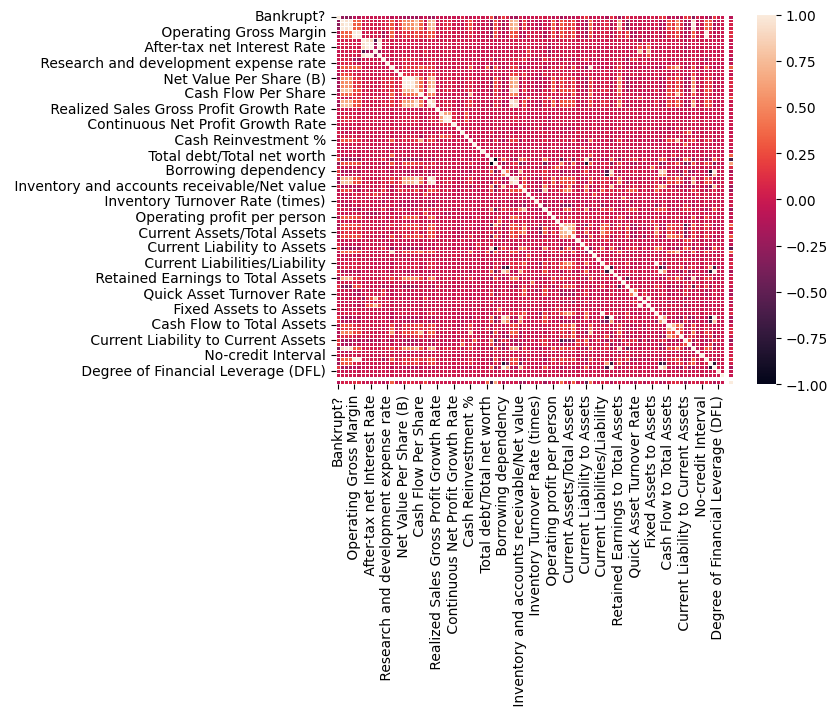

In [135]:
fig, ax = plt.subplots()
data_corr = df.corr()
sns.heatmap(data_corr, linewidths=0.5)

## Reg

In [136]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [137]:
data_corr = data_corr.abs()

sol = (data_corr.where(np.triu(np.ones(data_corr.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))

features = []
corr = []

for index, value in sol.items():
  if(index[0] == ' Net Income to Total Assets'):
      print(index[1],':', value)
      features.append(index[1])
      corr.append(value)

 Net Income to Stockholder's Equity : 0.32849183254448744
 Gross Profit to Sales : 0.30014565104815477
 Liability to Equity : 0.1596965181019577
 Total assets to GNP price : 0.10520070101982276
 Equity to Liability : 0.07391570862347022
 Interest Coverage Ratio (Interest expense to EBIT) : 0.012746126768264384
 No-credit Interval : 0.01194157755569632
 Degree of Financial Leverage (DFL) : 0.010462886108426423


In [138]:
X = df.drop(columns=' Net Income to Total Assets')
y = df[' Net Income to Total Assets']

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [140]:
models = {
    'LinearRegression': LinearRegression(),
    'ElasticNet': ElasticNet(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'RandomForestRegressor': RandomForestRegressor()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    results[name] = {
        'RMSE_train': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'RMSE_test': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'MAE_train': mean_absolute_error(y_train, y_pred_train),
        'MAE_test': mean_absolute_error(y_test, y_pred_test),
        'R2_train': r2_score(y_train, y_pred_train),
        'R2_test': r2_score(y_test, y_pred_test)
    }

In [141]:
results_df = pd.DataFrame(results).T
results_df

,RMSE_train,RMSE_test,MAE_train,MAE_test,R2_train,R2_test
LinearRegression,0.007124,2.718283e+07,0.003761,845047.059676,0.970146,-5.082982e+17
ElasticNet,0.040084,3.752625e-02,0.024079,0.023977,0.054850,3.127717e-02
GradientBoostingRegressor,0.002230,5.766100e-03,0.001453,0.002065,0.997076,9.771286e-01
KNeighborsRegressor,0.030986,3.671676e-02,0.019120,0.023557,0.435204,7.261974e-02
RandomForestRegressor,0.003293,5.395889e-03,0.000682,0.001648,0.993620,9.799712e-01


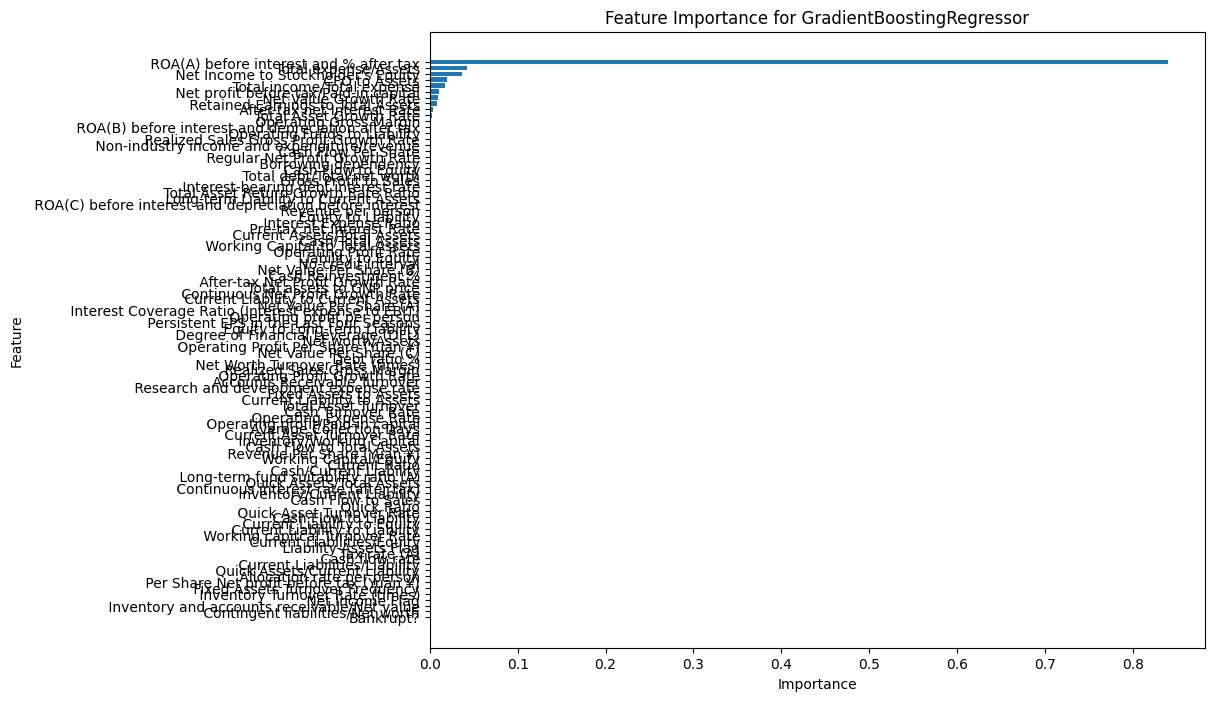

In [142]:
feature_importances = models['GradientBoostingRegressor'].feature_importances_

features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

features_df = features_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for GradientBoostingRegressor')
plt.show()

In [143]:
num_features_to_keep = 5

top_features = features_df.sort_values(by='Importance', ascending=False).head(num_features_to_keep)

X_top_features = X[top_features['Feature']]

X_train, X_test, y_train, y_test = train_test_split(X_top_features, y, test_size=0.3, random_state=42)

In [144]:
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [2]
}

grid_search_gb = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_grid=param_grid_gb, cv=3, scoring='neg_median_absolute_error', n_jobs=-1, verbose=3)

grid_search_gb.fit(X_train, y_train)

best_params_gb = grid_search_gb.best_params_
best_score_gb = np.sqrt(-grid_search_gb.best_score_)

best_params_gb, best_score_gb

Fitting 3 folds for each of 24 candidates, totalling 72 fits


({'learning_rate': 0.1,
  'max_depth': 5,
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'n_estimators': 200},
 nan)

In [145]:
cv_results = []
scores = cross_val_score(grid_search_gb.best_estimator_, X_top_features, y, cv=5, scoring='r2')
cv_results.append(scores)

cv_results

[array([0.97491998, 0.96073521, 0.96518645, 0.98829826, 0.98012359])]

In [146]:
train_sizes, train_scores, test_scores = learning_curve(grid_search_gb.best_estimator_, X_top_features, y, cv=3, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

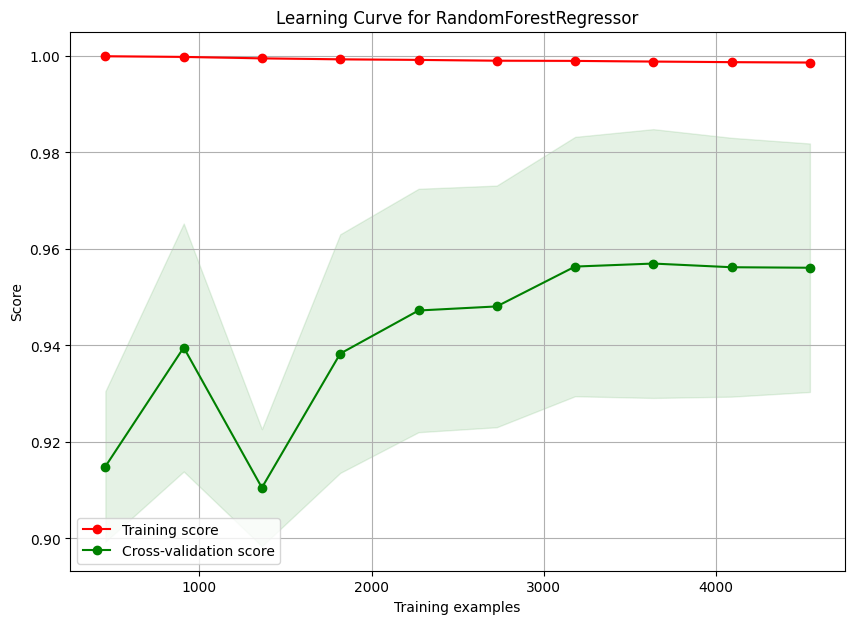

In [147]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 7))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curve for RandomForestRegressor")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

## Classification


In [148]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, classification_report

In [149]:
data_corr = data_corr.abs()

sol = (data_corr.where(np.triu(np.ones(data_corr.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))

features = []
corr = []

for index, value in sol.items():
  if(index[0] == 'Bankrupt?'):
      print(index[1],':', value)
      features.append(index[1])
      corr.append(value)

 Net Income to Total Assets : 0.31545697161429936
 ROA(A) before interest and % after tax : 0.28294058493448865
 ROA(B) before interest and depreciation after tax : 0.2730513178632931
 ROA(C) before interest and depreciation before interest : 0.2608065575202611
 Net worth/Assets : 0.25016096206661936
 Debt ratio % : 0.25016096206661775
 Persistent EPS in the Last Four Seasons : 0.2195596811907876
 Retained Earnings to Total Assets : 0.21777877998712378
 Net profit before tax/Paid-in capital : 0.20785651999287655
 Per Share Net profit before tax (Yuan ¥) : 0.201394834452866
 Current Liability to Assets : 0.19449443585543952
 Working Capital to Total Assets : 0.1930833758241344
 Net Income to Stockholder's Equity : 0.18098698840395136
 Borrowing dependency : 0.1765429361615994
 Current Liability to Current Assets : 0.17130604352180528
 Liability to Equity : 0.16681209778111403
 Net Value Per Share (A) : 0.16546475875891825
 Net Value Per Share (B) : 0.16539902110860744
 Net Value Per Sha

In [150]:
X = df.drop(columns='Bankrupt?')
y = df['Bankrupt?']

In [151]:
X.shape, y.shape

((6819, 95), (6819,))

In [152]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=0.35)
X, y = smote.fit_resample(X, y)
df = pd.concat([X, y], axis=1)
df.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,Bankrupt?
0,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,...,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469,1
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,...,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794,1
2,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,...,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474,1
3,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,0.781241,...,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982,1
4,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,...,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490,1


In [153]:
df = df.sample(frac=1).reset_index(drop=True)
X = df.drop(columns='Bankrupt?')
y = df['Bankrupt?']

In [154]:
X.shape, y.shape

((8908, 95), (8908,))

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [159]:
models = {
    'LogisticRegression': LogisticRegression(),
    'SGDClassifier': SGDClassifier(),
    'SVC': SVC(kernel='rbf', probability=True),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    results[name] = {
        'ROC_AUC_train': roc_auc_score(y_train, y_pred_train),
        'ROC_AUC_test': roc_auc_score(y_test, y_pred_test),
        'F1_train': f1_score(y_train, y_pred_train),
        'F1_test': f1_score(y_test, y_pred_test),
        'Recall_train': recall_score(y_train, y_pred_train),
        'Recall_test': recall_score(y_test, y_pred_test),
        'Precision_train' : precision_score(y_train, y_pred_train),
        'Precision_test' : precision_score(y_test, y_pred_test)
    }

In [160]:
results_df = pd.DataFrame(results).T
results_df

,ROC_AUC_train,ROC_AUC_test,F1_train,F1_test,Recall_train,Recall_test,Precision_train,Precision_test
LogisticRegression,0.528111,0.523637,0.157841,0.144431,0.095092,0.086892,0.464072,0.427536
SGDClassifier,0.532589,0.527201,0.227601,0.211066,0.164417,0.151694,0.369655,0.346801
SVC,0.643201,0.632294,0.450201,0.424702,0.309202,0.288660,0.827586,0.803279
KNeighborsClassifier,0.942941,0.911196,0.883015,0.826059,0.963190,0.933726,0.815161,0.740654
DecisionTreeClassifier,1.000000,0.921906,1.000000,0.875902,1.000000,0.893962,1.000000,0.858557


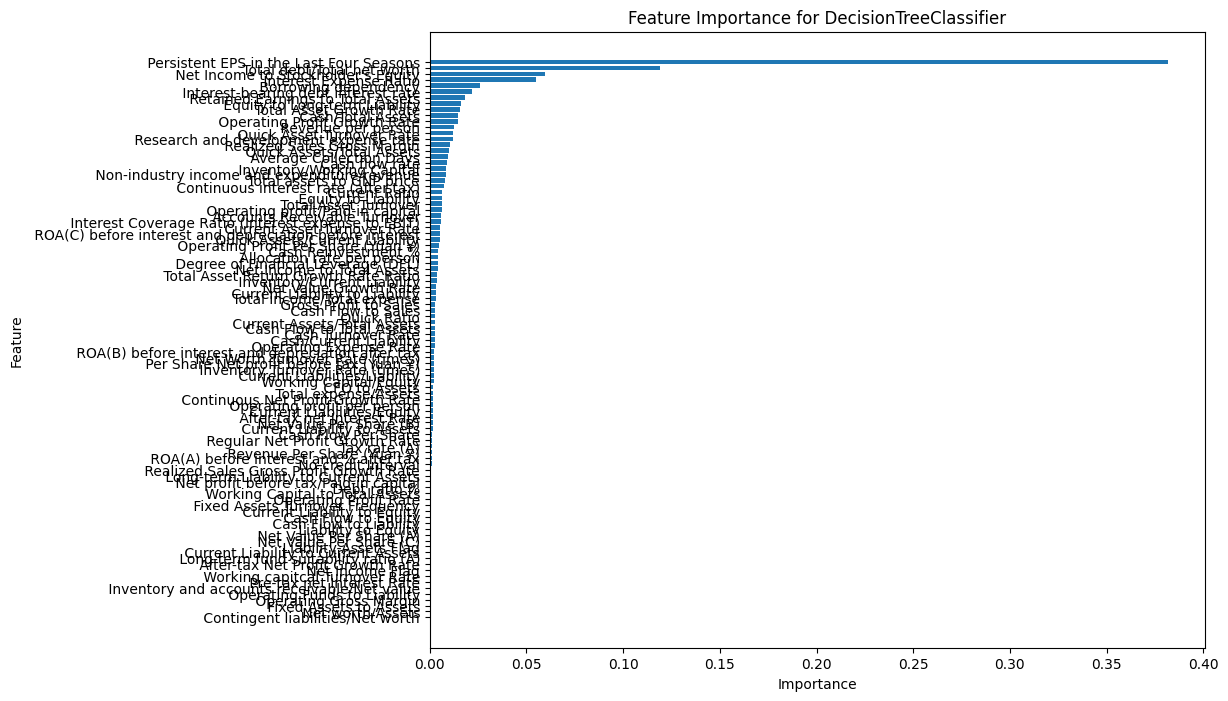

In [161]:
feature_importances = models['DecisionTreeClassifier'].feature_importances_

features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

features_df = features_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for DecisionTreeClassifier')
plt.show()

In [128]:
num_features_to_keep = X.shape[1] // 2

top_features = features_df.sort_values(by='Importance', ascending=False).head(num_features_to_keep)

X_top_features = X[top_features['Feature']]

X_train, X_test, y_train, y_test = train_test_split(X_top_features, y, test_size=0.3, random_state=42)

In [129]:
param_grid_gb = {'max_depth' : np.arange(0, 15, 1),
                 'min_samples_split' : np.arange(1, 7, 1),
                 'min_samples_leaf' : np.arange(1, 4, 1),
                 'criterion' :['gini', 'entropy', 'log_loss']
                }

grid_search_gb = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid_gb, cv=3, scoring='f1', n_jobs=-1, verbose=3)

grid_search_gb.fit(X_train, y_train)

best_params_gb = grid_search_gb.best_params_
best_score_gb = grid_search_gb.best_score_

best_params_gb, best_score_gb

Fitting 3 folds for each of 810 candidates, totalling 2430 fits


({'criterion': 'entropy',
  'max_depth': 13,
  'min_samples_leaf': 1,
  'min_samples_split': 6},
 0.9469473110446196)

In [130]:
cv_results = []
scores = cross_val_score(grid_search_gb.best_estimator_, X_test, y_test, cv=5, scoring='f1')
cv_results.append(scores)

cv_results

[array([0.93218249, 0.93218249, 0.94789082, 0.93184634, 0.93772894])]

In [131]:
train_sizes, train_scores, test_scores = learning_curve(grid_search_gb.best_estimator_, X_top_features, y, cv=3, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

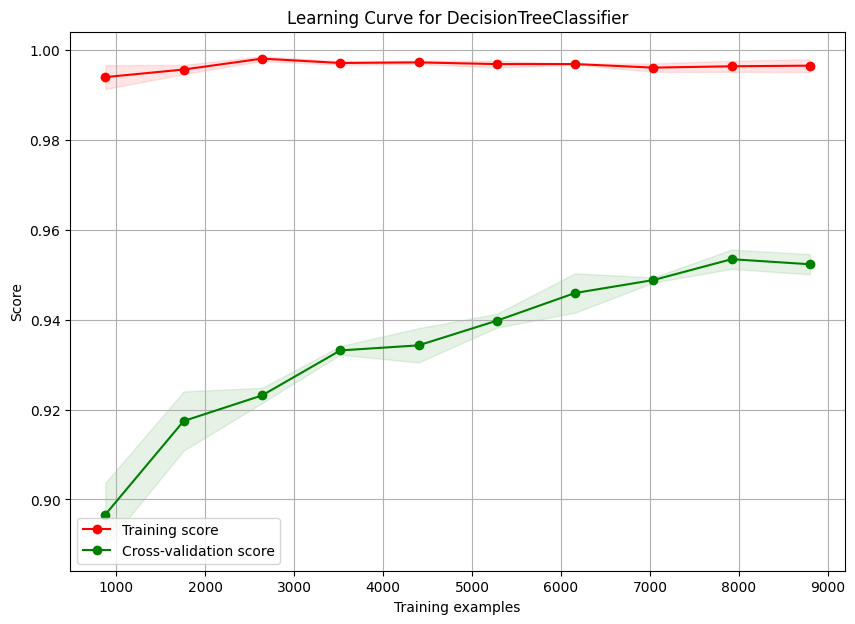

In [132]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 7))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curve for DecisionTreeClassifier")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

## Dimensionality reduction

In [167]:
from sklearn.decomposition import PCA

In [162]:
reg = GradientBoostingRegressor(random_state=42, learning_rate=0.1, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200)
X = df.drop(columns=' Net Income to Total Assets')
y = df[' Net Income to Total Assets']

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [164]:
X_train.shape

(6235, 95)

In [168]:
pca = PCA(n_components=len(X.columns)//4)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [170]:
X_train_pca.shape

(6235, 23)

In [172]:
reg.fit(X_train_pca, y_train)

y_pred = reg.predict(X_test_pca)

print("RMSE_test: ", np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE_test:  0.036455367603054005


In [175]:
classif = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=13, min_samples_leaf=1, min_samples_split=6)
X = df.drop(columns='Bankrupt?')
y = df['Bankrupt?']

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [177]:
X_train.shape

(6235, 95)

In [178]:
pca = PCA(n_components=len(X.columns)//3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [179]:
X_train_pca.shape

(6235, 31)

In [181]:
classif.fit(X_train_pca, y_train)

y_pred = classif.predict(X_test_pca)

print("F1_test: ", f1_score(y_test,y_pred))

F1_test:  0.8290960451977402
